In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import visual_behavior.data_access.loading as loading

### load multi-session data

what is needed for decoding analysis? 
* image aligned traces (including omissions)
* whether or not the image presentation was a change
* mean running speed, pupil diameter, and engagement metric value per image presentation
* all metadata for that experiment

TO DO: include mean pupil diameter in the stim_response_df

#### functions to load cell response data and stimulus presentations metadata for a set of sessions

In [4]:
experiments_table = loading.get_filtered_ophys_experiment_table()

In [9]:
# experiments_table.reset_index(inplace=True)

In [7]:
%%time 
#this can be slow for larger amounts of data. limiting to non-mesoscope production codes is faster.
project_codes = ['VisualBehaviorMultiscope']
session_numbers = [4]

stim_presentations = loading.get_concatenated_stimulus_presentations(project_codes, session_numbers)
stim_response_dfs = loading.get_concatenated_stimulus_response_dfs(project_codes, session_numbers)
stimulus_response_data = stim_response_dfs.merge(experiments_table, on=['ophys_experiment_id', 'ophys_session_id'])

# this last line merges the stimulus presentations into the stimulus_response_data, 
# but it often fails due to large dataframe size, so we will treat the data frames separately to start
# stimulus_response_data = stimulus_response_data.merge(stim_presentations, on='ophys_session_id')

problem for VisualBehaviorMultiscope Slc17a7-IRES2-Cre 4
Attribute 'block1_items_variety' does not exist in node: '/df'
CPU times: user 26.2 s, sys: 12.4 s, total: 38.6 s
Wall time: 1min 22s


In [8]:
# this has cell response data and all experiment metadata
stimulus_response_data.keys()

Index(['ophys_experiment_id', 'ophys_session_id', 'stimulus_presentations_id',
       'cell_specimen_id', 'trace', 'trace_timestamps', 'mean_response',
       'baseline_response', 'ophys_frame_rate', 'behavior_session_id',
       'container_id', 'project_code', 'container_workflow_state',
       'experiment_workflow_state', 'session_name', 'session_type',
       'equipment_name', 'date_of_acquisition', 'isi_experiment_id',
       'specimen_id', 'sex', 'age_in_days', 'full_genotype', 'reporter_line',
       'driver_line', 'imaging_depth', 'targeted_structure', 'published_at',
       'super_container_id', 'cre_line', 'session_tags', 'failure_tags',
       'exposure_number', 'model_outputs_available', 'location', 'has_events',
       'session_number'],
      dtype='object')

In [12]:
# this has stimulus presentations metadata for the same set of experiments
stim_presentations.keys()

Index(['ophys_session_id', 'stimulus_presentations_id', 'image_index',
       'image_name', 'image_name_next_flash', 'image_index_next_flash',
       'image_name_previous_flash', 'image_index_previous_flash', 'omitted',
       'change', 'pre_change', 'mean_running_speed', 'licked', 'rewarded',
       'reward_rate', 'hit_fraction', 'engagement_state',
       'lick_on_next_flash'],
      dtype='object')

In [13]:
# pick a Vip session
ophys_session_id = stimulus_response_data[stimulus_response_data.cre_line=='Vip-IRES-Cre'].ophys_session_id.unique()[0]
# get cell response data for this session
session_data = stimulus_response_data[stimulus_response_data.ophys_session_id==ophys_session_id].copy()
# get stimulus presentations data for this session
session_stimuli = stim_presentations[stim_presentations.ophys_session_id==ophys_session_id].copy()

# these two dataframes are linked by stimulus_presentations_id and ophys_session_id

In [15]:
session_data.iloc[0]['trace_timestamps'].shape, session_data.iloc[0]['trace'].shape

((13,), (13,))

In [ ]:
#image_index --> [0, .25]


In [16]:
session_data

,ophys_experiment_id,ophys_session_id,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,ophys_frame_rate,behavior_session_id,...,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,has_events,session_number
1429311,935514366,933439847,0,1028832095,"[-0.17192417690638828, -0.10087936870557397, -...","[-0.4661836057592707, -0.3729468846074166, -0....",0.079789,-0.017712,10.73,933504759,...,NaN,840355567,Vip-IRES-Cre,NaN,NaN,0,True,Vip_VISp_71,True,4
1429312,935514366,933439847,0,1028832582,"[-0.10670657996099717, 0.21769890875614098, -0...","[-0.4661836057592707, -0.3729468846074166, -0....",0.062780,0.092257,10.73,933504759,...,NaN,840355567,Vip-IRES-Cre,NaN,NaN,0,True,Vip_VISp_71,True,4
1429313,935514366,933439847,0,1028831625,"[0.06380861310592205, -0.04206825108114767, 0....","[-0.4661836057592707, -0.3729468846074166, -0....",0.062733,0.000480,10.73,933504759,...,NaN,840355567,Vip-IRES-Cre,NaN,NaN,0,True,Vip_VISp_71,True,4
1429314,935514366,933439847,0,1028832772,"[-0.019588022839854006, -0.10852957256893847, ...","[-0.4661836057592707, -0.3729468846074166, -0....",0.024200,0.003009,10.73,933504759,...,NaN,840355567,Vip-IRES-Cre,NaN,NaN,0,True,Vip_VISp_71,True,4
1429315,935514366,933439847,0,1028832779,"[-0.11147707535109455, 0.04882343961900136, -0...","[-0.4661836057592707, -0.3729468846074166, -0....",0.009895,-0.067906,10.73,933504759,...,NaN,840355567,Vip-IRES-Cre,NaN,NaN,0,True,Vip_VISp_71,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2172686,935514364,933439847,4793,1028826336,"[-0.04203548048280133, 0.00865223382310488, 0....","[-0.4661836057592707, -0.3729468846074166, -0....",0.000778,-0.011421,10.73,933504759,...,NaN,840355567,Vip-IRES-Cre,NaN,NaN,0,True,Vip_VISp_302,False,4
2172687,935514364,933439847,4794,1028826306,"[0.008957387258731485, -0.0078002063182496875,...","[-0.4661836057592707, -0.3729468846074166, -0....",-0.052871,-0.045847,10.73,933504759,...,NaN,840355567,Vip-IRES-Cre,NaN,NaN,0,True,Vip_VISp_302,False,4
2172688,935514364,933439847,4794,1028826336,"[-0.09607093690166217, 0.13266915997263648, 0....","[-0.4661836057592707, -0.3729468846074166, -0....",0.112905,0.117679,10.73,933504759,...,NaN,840355567,Vip-IRES-Cre,NaN,NaN,0,True,Vip_VISp_302,False,4
2172689,935514364,933439847,4795,1028826306,"[-0.03298763997876436, -0.09288862486973551, -...","[-0.4661836057592707, -0.3729468846074166, -0....",-0.031667,-0.059583,10.73,933504759,...,NaN,840355567,Vip-IRES-Cre,NaN,NaN,0,True,Vip_VISp_302,False,4


In [ ]:
session_stimuli

#### select changes

In [50]:
# population response vector for a change trial in that session 

# get change trial stimulus_presentation_ids
change_trials = session_stimuli[session_stimuli.change==True]
change_stimulus_presentation_ids = change_trials.stimulus_presentations_id.values
# get cell response data for those trials
change_data = session_data[session_data.stimulus_presentations_id.isin(change_stimulus_presentation_ids)]
# get responses for the first change trial
this_trial = change_stimulus_presentation_ids[0]
trial_data = change_data[change_data.stimulus_presentations_id==this_trial]
# what columns are available in the cell response data? 
trial_data.keys()

Index(['ophys_experiment_id', 'ophys_session_id', 'stimulus_presentations_id',
       'cell_specimen_id', 'trace', 'trace_timestamps', 'mean_response',
       'baseline_response', 'ophys_frame_rate', 'behavior_session_id',
       'container_id', 'project_code', 'container_workflow_state',
       'experiment_workflow_state', 'session_name', 'session_type',
       'equipment_name', 'date_of_acquisition', 'isi_experiment_id',
       'specimen_id', 'sex', 'age_in_days', 'full_genotype', 'reporter_line',
       'driver_line', 'imaging_depth', 'targeted_structure', 'published_at',
       'super_container_id', 'cre_line', 'session_tags', 'failure_tags',
       'exposure_number', 'model_outputs_available', 'location', 'has_events',
       'session_number'],
      dtype='object')

In [49]:
# what columns are available to use as labels? 
change_trials.keys()

Index(['ophys_session_id', 'stimulus_presentations_id', 'image_index',
       'image_name', 'image_name_next_flash', 'image_index_next_flash',
       'omitted', 'change', 'pre_change', 'mean_running_speed', 'licked',
       'rewarded', 'reward_rate', 'hit_fraction', 'engagement_state',
       'lick_on_next_flash'],
      dtype='object')

In [ ]:
# get reward data for this trial - if rewarded, its a hit, if not, its a miss
rewarded = change_trials[change_trials.stimulus_presentations_id==this_trial].rewarded.values[0]

In [40]:
# label for this trial - whether mouse correctly responded or not
rewarded

True

In [41]:
# all cell traces for this trial
trial_data.trace

1429617    [0.012363328227400168, 0.04944911768350993, 0....
1429618    [-0.03130673247658728, 0.03132648949937684, -0...
1429619    [-0.04907283881360015, 0.00292257680030553, 0....
1429620    [-0.07941507967824235, 0.09237048312163146, -0...
1429621    [0.03619254094410716, -0.00925070360707819, -0...
                                 ...                        
2110450    [0.0796573874628984, 0.008394976073131541, 0.0...
2110451    [-0.11772581998321235, -0.024870468238356428, ...
2110452    [-0.00529190003914155, 0.08613685494978711, -0...
2163117    [-0.16340084784558767, -0.15071787807477816, -...
2163118    [-0.06142803549223368, -0.12950276513213277, -...
Name: trace, Length: 155, dtype: object

Text(0.5, 1.0, 'population response for one change trial')

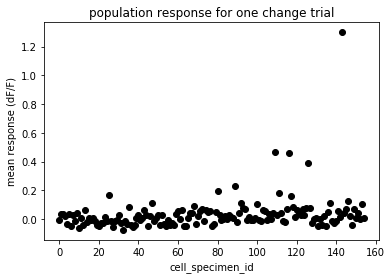

In [42]:
# population response vector for this trial
plt.plot(trial_data.mean_response.values, 'ok')
plt.xlabel('cell_specimen_id')
plt.ylabel('mean response (dF/F)')
plt.title('population response for one change trial')

#### select omissions

In [54]:
# population response vector for an omission trial in that session 

# get omission trial stimulus_presentation_ids
omission_trials = session_stimuli[session_stimuli.omitted==True]
omission_stimulus_presentation_ids = omission_trials.stimulus_presentations_id.values
# get cell response data for those trials
omission_data = session_data[session_data.stimulus_presentations_id.isin(omission_stimulus_presentation_ids)]
# get the first change trial
this_trial = omission_stimulus_presentation_ids[0]
trial_data = omission_data[omission_data.stimulus_presentations_id==this_trial]

In [55]:
# what columns are available to use as labels? 
omission_trials.keys()

Index(['ophys_session_id', 'stimulus_presentations_id', 'image_index',
       'image_name', 'image_name_next_flash', 'image_index_next_flash',
       'omitted', 'change', 'pre_change', 'mean_running_speed', 'licked',
       'rewarded', 'reward_rate', 'hit_fraction', 'engagement_state',
       'lick_on_next_flash'],
      dtype='object')

In [56]:
# get image index for next flash
image_index_next_flash = omission_trials[omission_trials.stimulus_presentations_id==this_trial].image_index_next_flash.values[0]

In [ ]:
# image shown at time 0
image_index = omission_trials[omission_trials.stimulus_presentations_id==this_trial].image_index.values[0]

In [58]:
# all cell traces for this trial
trial_data.trace

1429957    [0.0038385509307451507, -0.01104906011310088, ...
1429958    [-0.09382874164381957, -0.08599024139757776, 0...
1429959    [-0.087458122962857, -0.06430345081794989, -0....
1429960    [-0.03115527613901582, -0.028444007755090428, ...
1429961    [-0.048595958740559456, 0.026923073160912893, ...
                                 ...                        
2110560    [0.11805242208364283, 0.09369215294328054, -0....
2110561    [0.36981817992068816, 0.14912582327947746, -0....
2110562    [-0.027316564153548082, -0.05235505305811662, ...
2163137    [0.09415740157754365, 0.11828746350249301, -0....
2163138    [-0.016080139912552346, 0.037368204685545026, ...
Name: trace, Length: 155, dtype: object

Text(0.5, 1.0, 'population response for one omission trial')

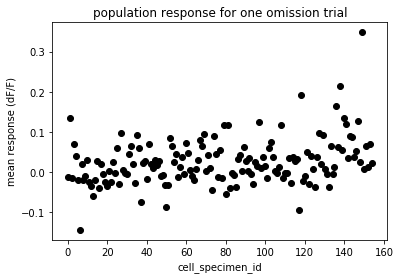

In [59]:
# population response vector for this trial
plt.plot(trial_data.mean_response.values, 'ok')
plt.xlabel('cell_specimen_id')
plt.ylabel('mean response (dF/F)')
plt.title('population response for one omission trial')

### underlying code

#### generating multi session dataframes (this can be done using the code below or by running cluster jobs with scripts in VBA which is much faster)

In [ ]:
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis

In [ ]:
# dont run below; it's just the example

In [ ]:
run_batch_processing = False

project_code = 'VisualBehaviorMultiscope'
cre_line = 'Vip-IRES-Cre'
session_number = 4 # novel images

save_dir = r'/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/decoding/data'

experiments_table = loading.get_filtered_ophys_experiment_table()
experiments = experiments_table[(experiments_table.project_code == project_code) &
                                (experiments_table.session_number == session_number)&
                                (experiments_table.cre_line == cre_line)].copy()

if run_batch_processing: # to prevent this from automatically running if you hit run all cells - it takes a while
    # get stimulus presentations data across sessions
    stim_df = pd.DataFrame()
    for ophys_session_id in experiments.ophys_session_id.unique():
        try:
            print(ophys_session_id, '-', np.where(experiments.ophys_session_id.unique()==ophys_session_id)[0][0],
                 'out of ', len(experiments.ophys_session_id.unique()))
            # get stimulus presentations data
            ophys_experiment_id = loading.get_ophys_experiment_id_for_ophys_session_id(ophys_session_id)
            dataset = loading.get_ophys_dataset(ophys_experiment_id)
            stim = dataset.extended_stimulus_presentations.copy()
            stim = stim.reset_index()
            # add columns
            stim['ophys_session_id'] = ophys_session_id
            if 'hit_fraction' not in stim.keys():
                stim['reward_rate'] = None
                stim['hit_fraction'] = None
                stim['engagement_state'] = None
                stim['lick_on_next_flash'] = None
            stim['rewarded'] = [True if len(rewards)>0 else False for rewards in stim.rewards.values]
            # select desired columns
            stim = stim[['ophys_session_id', 'stimulus_presentations_id', 'image_index', 'image_name',
                         'image_name_next_flash', 'image_index_next_flash',
                         'omitted', 'change', 'pre_change', 'mean_running_speed', 'licked', 'rewarded',
                         'reward_rate', 'hit_fraction', 'engagement_state', 'lick_on_next_flash']]
            # concatenate
            stim_df = pd.concat([stim_df, stim])
        except Exception as e:
            print('problem for ophys_session_id:', ophys_session_id)
            print(e)
    # save dataframe to standardized location
    # stim_df.to_hdf(os.path.join(save_dir, 'stimulus_presentations_'+project_code+'_session_'+str(session_number)+'.h5'), key='df')


    # get stimulus response dfs
    response_df = pd.DataFrame()
    for ophys_experiment_id in experiments.index.values:
        try:
            print(ophys_experiment_id, '-', np.where(experiments.index.values == ophys_experiment_id)[0][0],
                  'out of ', len(experiments.index.values))
            # get stimulus responses for this experiment
            dataset = loading.get_ophys_dataset(ophys_experiment_id)
            analysis = ResponseAnalysis(dataset, use_extended_stimulus_presentations=False)
            stim_response_df = analysis.get_response_df(df_name='stimulus_response_df')
            sdf = stim_response_df.copy()
            # limit to [0, 0.75] second window
            sdf['trace'] = [sdf.iloc[index].trace[sdf.iloc[index].trace_timestamps < 0] for index in sdf.index.values]
            # modify and select desired columns
            sdf['ophys_experiment_id'] = ophys_experiment_id
            sdf['ophys_session_id'] = loading.get_ophys_session_id_for_ophys_experiment_id(ophys_experiment_id)
            sdf['ophys_frame_rate'] = np.round(analysis.ophys_frame_rate, 2)
            sdf = sdf[['ophys_experiment_id', 'ophys_session_id','stimulus_presentations_id', 'cell_specimen_id', 'trace',
                       'trace_timestamps', 'mean_response', 'baseline_response', 'ophys_frame_rate']]
            # concatenate
            response_df = pd.concat([response_df, sdf])
        except Exception as e:
            print('problem for ophys_experiment_id:', ophys_experiment_id)
            print(e)
    # save dataframe to standardized location
    # response_df.to_hdf(os.path.join(save_dir, 'stimulus_response_dfs_'+project_code+'_'+cre_line+'_session_'+str(session_number)+'.h5'), key='df')

    
    # merge cell responses with stimulus information
    stimulus_response_data = response_df.merge(stim_presentations, on='ophys_session_id')
    # merge with experiment level metadata
    stimulus_response_data = stimulus_response_data.merge(experiments_table, on='ophys_experiment_id') 

In [ ]:
stimulus_response_data.keys()

#### loading previously generated dataframes - these are all in VBA in data_access.loading, shown here just for reference

In [ ]:
def get_concatenated_stimulus_presentations(project_codes=None, session_numbers=None):
    """
    loads stimulus presentation table data for multiple sessions from cached files.
    dataframe contains stimulus information including image_name, change, licked, omitted, etc for every stimulus presentation.
    can be merged with stimulus_response_dfs to get cell responses for all stimulus presentations.

    if desired project codes and session numbers are not specified, all data will be loaded.
    project_codes and session_numbers should be provided as lists,
    ex: project_codes = ['VisualBehaviorTask1B', 'VisualBehaviorMultiscope], session_numbers = [3, 4]
    """

    save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\decoding\data'
    experiments_table = get_filtered_ophys_experiment_table()
    if project_codes is None:
        project_codes = experiments_table.project_code.unique()
    if session_numbers is None:
        session_numbers = experiments_table.session_number.unique()

    concatenated_stimulus_presentations = pd.DataFrame()
    for project_code in project_codes:
        for session_number in session_numbers:
            try:
                df = pd.read_hdf(os.path.join(save_dir, 'stimulus_presentations_' + project_code + '_session_' + str(
                    session_number) + '.h5'), key='df')
                concatenated_stimulus_presentations = pd.concat([concatenated_stimulus_presentations, df])
            except Exception as e:
                print('problem for', project_code, session_number)
                print(e)
    return concatenated_stimulus_presentations


def get_concatenated_stimulus_response_dfs(project_codes=None, session_numbers=None):
    """
    loads stimulus response dataframes for multiple sessions from cached files.
    dataframe contains the response of each cell for each stimulus presentation across sessions,
    including the trace in a [0, 0.75] second window, the mean response in that window, etc.
    can be merged with stimulus presentations to get the stimulus conditions for each cell response.

    if desired project codes and session numbers are not specified, all data will be loaded.
    project_codes and session_numbers should be provided as lists,
    ex: project_codes = ['VisualBehaviorTask1B', 'VisualBehaviorMultiscope], session_numbers = [3, 4]
    """

    save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\decoding\data'
    experiments_table = get_filtered_ophys_experiment_table()
    if project_codes is None:
        project_codes = experiments_table.project_code.unique()
    if session_numbers is None:
        session_numbers = experiments_table.session_number.unique()
    cre_lines = experiments_table.cre_line.unique()

    concatenated_stimulus_response_dfs = pd.DataFrame()
    for project_code in project_codes:
        for session_number in session_numbers:
            for cre_line in cre_lines:
                try:
                    df = pd.read_hdf(os.path.join(save_dir, 'stimulus_response_dfs_'+project_code+'_'+cre_line+'_session_'+str(session_number)+'.h5'), key='df')
                    concatenated_stimulus_response_dfs = pd.concat([concatenated_stimulus_response_dfs, df])
                except Exception as e:
                    print('problem for', project_code, cre_line, session_number)
                    print(e)
    return concatenated_stimulus_response_dfs


def get_stimulus_response_data_across_sessions(project_codes=None, session_numbers=None):
    """
    loads and merges stimulus_response_dfs, stimulus_presentations data, and experiments_table metadata
    across sessions for a given set of project_codes and session_numbers. 
    returns all cell responses for all image flashes for that set of sessions.
    
    if desired project codes and session numbers are not specified, all data will be loaded (slow).
    project_codes and session_numbers should be provided as lists,
    ex: project_codes = ['VisualBehaviorTask1B', 'VisualBehaviorMultiscope], session_numbers = [3, 4]
    """
    
    save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\decoding\data'
    experiments_table = loading.get_filtered_ophys_experiment_table()
    if project_codes is None: 
        project_code = experiments_table.project_code.unique()
    if session_numbers is None:
        session_numbers = experiments_table.session_number.unique()
    
    stim_presentations = loading.get_concatenated_stimulus_presentations(project_codes, session_numbers)
    stim_response_dfs = loading.get_concatenated_stimulus_response_dfs(project_codes, session_numbers)
    stimulus_response_data = stim_response_dfs.merge(stim_presentations, on='ophys_session_id')
    stimulus_response_data = stimulus_response_data.merge(experiments_table, on='ophys_experiment_id')
    return stimulus_response_data

#### using convenience function to load desired sessions


In [ ]:
%%time
project_codes = ['VisualBehavior']
session_numbers = [4]
data = loading.get_stimulus_response_data_across_sessions(project_codes, session_numbers)

In [ ]:
data.keys()

## FN code

In [ ]:
cols = ['session_id', 'experiment_id', 'mouse_id', 'date', 'cre', 'stage', 'area', 'depth', 'frame_dur', 'omission_response_xr', 'trials_response_df', 'image_names_inds', 'run_speed_times', 'run_speed_traces'] 
all_sess_allN_allO = pd.DataFrame([], columns=cols) # size: 8*len(num_sessions)
errors_iexp = []
errors_log = []
for iexp in np.arange(0, experiments_table_2an.shape[0]): # iexp = 0 
    experiment_id = experiments_table_2an.index[iexp]     # experiments_table_2an.iloc[experiments_table_2an.index == ophys_experiment_id]
    session_id = experiments_table_2an.iloc[iexp]['ophys_session_id']
#     session_id = experiments_table[experiments_table.index.values==ophys_experiment_id].iloc[0]['ophys_session_id']
    print(f'\n\n------------ Setting vars for experiment_id {experiment_id} , session_id {session_id} , ({iexp} / {experiments_table_2an.shape[0]}) ------------\n\n')
    cre = experiments_table_2an.iloc[iexp]['cre_line']
    date = experiments_table_2an.iloc[iexp]['date_of_acquisition'][:10]
    stage = experiments_table_2an.iloc[iexp]['session_type']
    area = experiments_table_2an.iloc[iexp]['targeted_structure']
    depth = int(experiments_table_2an.iloc[iexp]['imaging_depth'])
    project_code = experiments_table_2an.iloc[iexp]['project_code']
    session_name = str(experiments_table_2an.iloc[iexp]['session_name'])
    uind = [m.start() for m in re.finditer('_', session_name)]
    mid = session_name[uind[0]+1 : uind[1]]
    if len(mid)<6: # a different nomenclature for session_name was used for session_id: 935559843
        mouse_id = int(session_name[uind[-1]+1 :])
    else:
        mouse_id = int(mid)
    try:
        # get SDK dataset through VBA loading function # this function gets an SDK session object then does a bunch of reformatting to fix things
        dataset = loading.get_ophys_dataset(experiment_id, include_invalid_rois=False)
        frame_dur = np.mean(np.diff(dataset.ophys_timestamps))
        n_neurons = dataset.dff_traces.shape[0]
        if n_neurons > 0: # get 3d traces: frames x trials x units
            omission_response_xr = get_omission_response_xr(dataset, use_events=False, frame_rate=None)
        #     n_omissions = omission_response_xr['trial_id'].values.shape[0] 
        #     n_neurons = omission_response_xr['trace_id'].values.shape[0]
        #     time_trace = omission_response_xr['eventlocked_timestamps'].values
        #     traces_ftu = omission_response_xr['eventlocked_traces'].values # frames x trials x neurons
            # the cell_ids defined below is same as cell_ids.astype(int)[:n_neurons] when cell_ids is defined out of omission_response_df
        #     cell_ids = omission_response_xr['trace_id'].values
        else:
            omission_response_xr = np.nan
        #%% ResponseAnalysis class provides access to time aligned cell responses for trials, stimuli, and omissions
        # VBA also has useful functionality for creating data frames with cell traces aligned to the time of stimulus presentations, omissions, or behavioral trials. 
        analysis = ResponseAnalysis(dataset)  
        #%% Keep image names
        stim_response_df = analysis.get_response_df(df_name='stimulus_response_df')
#         np.shape(stim_response_df) # (neurons x flashes) x 19 (columns)
        cell0 = stim_response_df['cell_specimen_id'].values[0] # get flashes for one of the cells
        s = stim_response_df[stim_response_df['cell_specimen_id'].values==cell0]
        image_names_inds = s[['stimulus_presentations_id', 'image_index', 'image_name']]
        #%% Get image-change aligned traces
        trials_response_df = analysis.get_response_df(df_name='trials_response_df')
        #%% Get running speed for omission-aligned traces 
        run_speed_df = analysis.get_response_df(df_name='omission_run_speed_df')
#         run_speed_df.head()
#         np.shape(run_speed_df)
        # running speed averaged across all omissions
        run_speed_times = run_speed_df['trace_timestamps'].values[0] # times (60Hz)
        run_speed_traces = np.vstack(run_speed_df['trace']).T # times x omissions (remember the last omission is missing due to some issues in responseAnalysis)
#         plt.plot(run_speed_times, run_speed_df.trace.mean())
#         plt.title('average omission triggered running behavior')
#         plt.xlabel('time after omission (s)')
#         plt.ylabel('run speed (cm/s)')
        #%% Get pupil area for omission-aligned traces 
        # this part didnt work; wrote marina/doug about it:
        '''
        pupil_area_df = analysis.get_response_df(df_name='omission_pupil_area_df')
        pupil_area_df.head()
        np.shape(pupil_area_df)
        # pupil area averaged across all omissions
        pupil_times = pupil_area_df['trace_timestamps'].values[0] # times (60Hz)
        pupil_traces = np.vstack(pupil_area_df['trace']).T # times x neurons
#         plt.plot(run_times, run_speed_df.trace.mean())
#         plt.title('average omission triggered running behavior')
#         plt.xlabel('time after omission (s)')
#         plt.ylabel('run speed (cm/s)')
        '''
        '''
        # get omission triggered responses 
        omission_response_df = analysis.get_response_df(df_name='omission_response_df')
        cell_ids = omission_response_df['cell_specimen_id'].values.astype(float)
        if np.isnan(cell_ids).any(): # cell matching has not been run, just copy cell roi ids to cell specimen ids
            print(f'\n\n Warning! experiment {experiment_id} does not have cell_specimen_id; using cell_roi_id instead....\n\n')
            dataset.dff_traces.index = dataset.dff_traces.cell_roi_id
            analysis = ResponseAnalysis(dataset) 
            omission_response_df = analysis.get_response_df(df_name='omission_response_df')
        frame_dur = np.mean(np.diff(omission_response_df['trace_timestamps'].iloc[iexp]))
    #     n_neurons = len(np.unique(omission_response_df['cell_specimen_id']))
        n_omissions = int(omission_response_df.shape[0] / n_neurons)
    #     sum(dataset.stimulus_presentations['omitted']==True)
    #     sum(stim_response_df['omitted']) / n_neurons
    #     a = omission_response_df[['cell_specimen_id', 'trace', 'trace_timestamps']]
        traces_allN_allO = np.vstack(omission_response_df['trace'].values) # all neurons and all omissions x frames (107)  # all neurons, omission 1, then all neurons omission 2, etc.... all neuron traces for all omissions are concatenated.
        '''
        all_sess_allN_allO.at[iexp, ['session_id', 'experiment_id', 'mouse_id', 'date', 'cre', 'stage', 'area', 'depth', \
                                     'frame_dur', 'omission_response_xr', 'trials_response_df', 'image_names_inds', 'run_speed_times', 'run_speed_traces']] = \
            session_id ,  experiment_id ,  mouse_id ,  date ,  cre ,  stage ,  area ,  depth ,  frame_dur ,  omission_response_xr, trials_response_df, image_names_inds, run_speed_times, run_speed_traces
    #     all_sess_allN_allO.at[iexp, ['session_id', 'experiment_id', 'mouse_id', 'date', 'cre', 'stage', 'area', 'depth', \
    #                                  'n_omissions', 'n_neurons', 'frame_dur', 'cell_specimen_id', 'traces_allN_allO']] = \
    #         session_id ,  experiment_id ,  mouse_id ,  date ,  cre ,  stage ,  area ,  depth ,  n_omissions ,  n_neurons ,  frame_dur ,  cell_ids , traces_allN_allO
    except Exception as e:
        print(e)
        errors_iexp.append(iexp)
        errors_log.append(e)